In [1]:
import skimage
import skimage.io
import os, sys
import utils
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import mywarper

## Read in the mean landmark

In [ ]:
mdict = scipy.io.loadmat("PCA_Train_Data_LandMark.mat")
mean_LM = mdict["mean_landmark"]
X_LM = mdict["train_data"]
X_LM_center =  X_LM - mean_LM

In [ ]:
Pseudo_Cov_Matrix = np.matmul(X_LM_center, np.transpose(X_LM_center))
P_eigen_vector, P_engen_value, _ = np.linalg.svd(Pseudo_Cov_Matrix)

## Calculate first 50 eigen-warping

In [ ]:
for i in range(50):
    if i == 0:
        cur_warping = np.matmul(np.transpose(X_LM_center), P_eigen_vector[:, i])
        eigen_warping =  np.expand_dims(cur_warping / np.sqrt(np.dot(cur_warping, cur_warping)), axis = 0)
    else:
        cur_warping = np.matmul(np.transpose(X_LM_center), P_eigen_vector[:, i])
        eigen_warping = np.concatenate((eigen_warping, np.expand_dims(cur_warping / np.sqrt(np.dot(cur_warping, cur_warping)), axis = 0)), axis = 0)

In [ ]:
mdict = {"eigen_warping": eigen_warping, "mean_warping": mean_LM}
scipy.io.savemat("PCA_eigen_mean_warping.mat", mdict)

## Read in the eigen warpings

In [ ]:
mdict = scipy.io.loadmat("PCA_eigen_mean_warping.mat")
mean_LM = mdict["mean_warping"]
eigen_warping = mdict["eigen_warping"]
target_LM = mean_LM.reshape(68, 2)

## Warp the training images into the mean postion

In [4]:
image_folder = os.path.join(os.getcwd(), "images")
image_files = utils.files_under_folder_with_suffix(image_folder, suffix = '.jpg')
train_set_im = image_files[:800]

landmark_folder = os.path.join(os.getcwd(), "landmarks")
LM_files = utils.files_under_folder_with_suffix(landmark_folder, suffix = '.mat')
train_set_LM = LM_files[:800]

aligned_folder = os.path.join(os.getcwd(), "aligned_images")

In [ ]:
utils.generate_aligned_images(image_folder, landmark_folder, train_set_im, train_set_LM, aligned_folder, target_LM)

## Compute the first 50 eigen-face

In [ ]:
mean_image, X = utils.X_mean_V_chanel(aligned_folder, train_set_im)

In [ ]:
print(mean_image.shape, X.shape)

In [ ]:
X_center = X - mean_image
Pseudo_Cov_Matrix = np.matmul(X_center, np.transpose(X_center))
P_eigen_vector, P_engen_value, _ = np.linalg.svd(Pseudo_Cov_Matrix)
for i in range(50):
    if i == 0:
        cur_face = np.matmul(np.transpose(X_center), P_eigen_vector[:, i])
        eigen_face =  np.expand_dims(cur_face / np.sqrt(np.dot(cur_face, cur_face)), axis = 0)
    else:
        cur_face = np.matmul(np.transpose(X_center), P_eigen_vector[:, i])
        eigen_face = np.concatenate((eigen_face, np.expand_dims(cur_face / np.sqrt(np.dot(cur_face, cur_face)), axis = 0)), axis = 0)

In [2]:
mdict = {"mean_image": mean_image, "aligned_eigen_face": eigen_face}
scipy.io.savemat("PCA_Aligned_Eigen_Face.mat", mdict)

NameError: name 'mean_image' is not defined

## Warp the test images into the mean postion

In [5]:
test_set_im = image_files[800:]
test_set_LM = LM_files[800:]

In [ ]:
utils.generate_aligned_images(image_folder, landmark_folder, test_set_im, test_set_LM, aligned_folder, target_LM)

## Project the test images to the 10-eigen-warpings

In [18]:
_, X_test = utils.LM_mean_LM_data(landmark_folder, test_set_LM)

In [19]:
mdict = scipy.io.loadmat("PCA_Eigen_warping.mat")
mean_LM = mdict["mean_LM"]
eigen_warping = mdict["eigen_warping"][:10, :] # top 10 eigen warpings

In [20]:
coef = np.matmul(X_test - mean_LM, eigen_warping.T)
recons_LM = np.matmul(coef, eigen_warping) + mean_LM
recons_LM = recons_LM.reshape((recons_LM.shape[0], 68, 2))
# recons_LM[:, :, 1] = -recons_LM[:, :, 1]

## Project the test images to top 50-eigen-faces 

In [ ]:
_, X_test = utils.X_mean_V_chanel(aligned_folder, test_set_im)
X_test.shape

In [11]:
mdict = scipy.io.loadmat("PCA_Aligned_Eigen_Face.mat")
mean_image = mdict["mean_image"]
eigen_face = mdict["aligned_eigen_face"]

In [12]:
_, X_re = utils.reconstruct_image(aligned_folder, test_set_im, mean_image, eigen_face)

In [13]:
X_re.shape

(200, 49152)

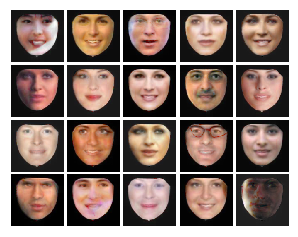

In [14]:
fig_re = utils.plot(X_re[50:70, :], 10, 5, 3, 128, 128)

## Warp back to the original landmark

In [15]:
X_re = X_re.reshape((X_re.shape[0], 128, 128, 3))

In [ ]:
Mean_LM = mean_LM.reshape((68, 2))
for i in range(X_re.shape[0]):
    final_im = mywarper.warp(X_re[i, :, :, :], Mean_LM, recons_LM[i, :, :])
    if i == 0:
        Final_im = np.expand_dims(final_im, axis = 0)
    else:
        Final_im = np.concatenate([Final_im, np.expand_dims(final_im, axis = 0)], axis = 0)

## Plot 20 Reconstructed Faces and original faces

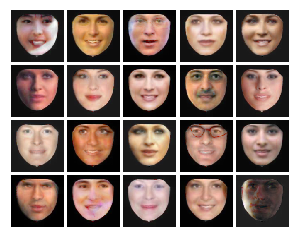

In [17]:
fig_re = utils.plot(Final_im[50:70], 4, 5, 3, 128, 128)
fig_re.savefig("7_20_reconstructed_faces.png")

In [ ]:
X, _ = utils.reconstruct_image(image_folder, test_set_im, mean_image, eigen_face)

In [ ]:
fig_org = utils.plot(X[50:70], 4, 5, 3, 128, 128)
fig_org.savefig("8_20_org_faces.png")